In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import sem, t

In [4]:
'''We define here the functions that will be used throughout the code'''

def read_tsp(name): # Read the tsp file and create a list of the nodes coordinates

    lines = open(name, 'r').readlines() # Open the file and devide it in lines
    nodes = []

    for line in lines[lines.index('NODE_COORD_SECTION\n') + 1:lines.index('EOF\n')]: # Loop only through the lines of interest in the file
        _, x, y = map(float, line.split()) # Extract the x and y of the coordinates for each node/line
        nodes.append((x, y))

    return np.array(nodes)

def distance_matrix(nodes): # Create a matrix that contains every distance between each node

    n = len(nodes)
    dist_matrix = np.zeros((n, n)) # Create an empty nxn matrix

    for i in range(n): # Loop through each node and calculate the distance between this node and all the others for each other node
        for j in range(n):
            dist_matrix[i, j] = np.linalg.norm(nodes[i] - nodes[j])

    return dist_matrix

def tot_distance(tour, dist_matrix): # Calculate the total distance of the tour

    return sum(dist_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1)) + dist_matrix[tour[-1], tour[0]] # Sum the distancec between the nodes in the tour (in their order), plus the distance between the last and first node (the salesman must come back to the first node)

def two_opt(tour): # Perform two opt swap
    
    n = len(tour)

    while True:
        i, j = sorted(random.sample(range(n), 2))
        if abs(i - j) > 1: # Ensure edges are non-adjacent
            break
    
    if i != (n - 1) and j != (n - 1): # Case where the i^th and j^th components are not the last in the list
        new_tour = tour[:i+1] + [tour[j+1]] + [tour[i+1]] + tour[i+2:j+1] + tour[j+2:]
        return new_tour
    elif i == (n - 1): # Case where the i^th component is the last of the list
        new_tour = [tour[i]] + [tour[j+1]] + tour[:j+1] + tour[j+2:i]
        return new_tour
    elif j == (n - 1): # Case wehre the j^th component is the last of the list
        new_tour = [tour[j]] + [tour[i+1]] + tour[:i+1] + tour[i+2:j]
        return new_tour

def simulated_annealing(dist_matrix, T0, cooling_rate, mc_length, max_iterations): # Perform optimization of the total distance through simulated annealing
    
    # Create a random starting tour and calculate its total distance
    n = len(dist_matrix)
    present_tour = list(range(n))
    random.shuffle(present_tour)
    present_dist = tot_distance(present_tour, dist_matrix)

    # Set the best-so-far tour and distance to the random one just created
    opt_tour = present_tour[:]
    opt_dist = present_dist

    T = T0 # Set an initial temperature

    dic_result = {}

    for iteration in range(max_iterations): # Loop through a maximum number of iterations
        for _ in range(mc_length): # Loop through a markov chain before updating the temperature

            new_tour = two_opt(present_tour) # Perform a two opt swap in the present tour
            new_dist = tot_distance(new_tour, dist_matrix) # Calculate the total distance of this new tour

            # If the new distance is lower that the best-so-far one or a random number is lower than the temperature-based parameter computed below (set to be maximum = 1), focus on the new tour found
            if new_dist < present_dist or random.random() <= min(math.exp((present_dist - new_dist) / T), 1): 
                present_tour, present_dist = new_tour, new_dist

                if present_dist < opt_dist: # Update the estimates if this new tour is shorter that the best-so-far
                    opt_tour, opt_dist = present_tour[:], present_dist
                
        T *= cooling_rate # Upgrade the temperature according the cooling rate
        if T < 1e-12: # Break the loop if the temperature becomes too small
            break

        dic_result[iteration] = opt_dist
        # To observe convergence while coding we used: print(f'Iteration: {iteration}; opt. dist.: {opt_dist}')

    return opt_tour, opt_dist, dic_result

def read_tsp_opt(name): # Read the file containing the optimum lenght 

    lines = open(name, 'r').readlines() # Create a list of all the lines
    nodes = []

    for line in lines[lines.index('TOUR_SECTION\n') + 1:lines.index('-1\n') + 1]: # Loop only through the lines of interest in the file
        if int(line) != -1: # Other than the last line (which indicates to come back to the first node), deacrease the line-value by one to reflect python-indexes style
            nodes.append(int(line) - 1)

    return np.array(nodes) # Return the true optimal tour

def confidence_interval(data, confidence = 0.95): # Calculate the 95% CI for some given data
    n = len(data)
    mean = np.mean(data, axis = 0)
    se = sem(data, axis = 0)
    ci = se * t.ppf((1 + confidence) / 2, n - 1)
    return mean, ci

In [3]:
'''We perform simulated annealing on the 51-cities problem'''

# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
name = "eil51.tsp.txt"
nodes = read_tsp(name)
dist_matrix = distance_matrix(nodes)

# Set the parameters
T0 = 1000
cooling_rate = 0.9993
mc_length = 500
max_iterations = 11000

# Perform simulated annealing
opt_tour, opt_dist, _ = simulated_annealing(dist_matrix, T0, cooling_rate, mc_length, max_iterations)

# Print solution
print('Shortest tour: ', opt_tour)
print('Distance: ', opt_dist)

# Compute the true optimal distance from the provided files and compare it with the obtained solution
true_opt = tot_distance(tour = read_tsp_opt("eil51.opt.tour.txt"), dist_matrix = dist_matrix)
print(f'True optimal distance: {true_opt}; difference = {opt_dist - true_opt}')

Shortest tour:  [4, 36, 16, 3, 40, 12, 39, 18, 41, 43, 14, 44, 32, 38, 9, 29, 48, 8, 33, 20, 49, 15, 1, 28, 19, 34, 35, 2, 30, 27, 21, 0, 26, 7, 25, 6, 47, 5, 22, 42, 23, 13, 24, 17, 46, 11, 45, 50, 31, 10, 37]
Distance:  467.684296267222
True optimal distance: 429.98331198338406; difference = 37.700984283837954


In [4]:
'''We perform simulated annealing on the 280-cities problem'''

# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
name = "a280.tsp.txt"
nodes = read_tsp(name)
dist_matrix = distance_matrix(nodes)

# Set the parameters
T0 = 1000
cooling_rate = 0.9993
mc_length = 500
max_iterations = 11000

# Perform simulated annealing
opt_tour, opt_dist, _ = simulated_annealing(dist_matrix, T0, cooling_rate, mc_length, max_iterations)

# Print solution
print('Shortest tour: ', opt_tour)
print('Distance: ', opt_dist)

# Compute the true optimal distance from the provided files and compare it with the obtained solution
true_opt = tot_distance(tour = read_tsp_opt("a280.opt.tour.txt"), dist_matrix = dist_matrix)
print(f'True optimal distance: {true_opt}; difference = {opt_dist - true_opt}')

Shortest tour:  [61, 116, 117, 60, 59, 42, 118, 156, 119, 120, 121, 153, 154, 152, 155, 151, 134, 135, 136, 266, 267, 268, 269, 261, 260, 258, 259, 276, 278, 3, 4, 0, 1, 279, 2, 277, 257, 262, 263, 264, 265, 137, 138, 147, 148, 149, 177, 150, 122, 123, 124, 29, 30, 33, 34, 35, 37, 38, 39, 40, 41, 44, 46, 45, 43, 58, 57, 67, 66, 65, 72, 71, 70, 69, 68, 56, 55, 54, 53, 52, 47, 48, 51, 50, 49, 36, 32, 31, 28, 125, 126, 128, 127, 20, 129, 130, 19, 27, 26, 25, 21, 24, 22, 23, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 275, 274, 273, 272, 271, 270, 15, 16, 132, 17, 18, 131, 133, 139, 140, 146, 141, 145, 142, 143, 144, 198, 197, 200, 199, 201, 202, 203, 204, 205, 206, 207, 212, 211, 210, 209, 208, 252, 251, 254, 253, 256, 255, 248, 247, 249, 246, 244, 243, 241, 242, 240, 239, 238, 245, 250, 229, 228, 227, 213, 214, 215, 216, 219, 218, 221, 222, 217, 195, 196, 193, 192, 191, 194, 225, 226, 232, 231, 230, 237, 236, 235, 234, 233, 224, 223, 220, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179

In [5]:
'''We perform simulated annealing on the 442-cities problem'''

# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
name = "pcb442.tsp.txt"
nodes = read_tsp(name)
dist_matrix = distance_matrix(nodes)

# Set the parameters
T0 = 1000
cooling_rate = 0.9993
mc_length = 500
max_iterations = 11000

# Perform simulated annealing
opt_tour, opt_dist, _ = simulated_annealing(dist_matrix, T0, cooling_rate, mc_length, max_iterations)

# Print solution
print('Shortest tour: ', opt_tour)
print('Distance: ', opt_dist)

# Compute the true optimal distance from the provided files and compare it with the obtained solution
true_opt = tot_distance(tour = read_tsp_opt("pcb442.opt.tour.txt"), dist_matrix = dist_matrix)
print(f'True optimal distance: {true_opt}; difference = {opt_dist - true_opt}')

Shortest tour:  [371, 370, 431, 369, 368, 367, 366, 344, 364, 365, 329, 328, 303, 304, 305, 330, 331, 332, 333, 306, 334, 335, 426, 436, 274, 422, 437, 271, 419, 267, 415, 263, 236, 264, 413, 410, 219, 225, 209, 198, 183, 170, 159, 147, 134, 124, 112, 382, 383, 97, 96, 379, 95, 378, 94, 93, 61, 62, 63, 64, 31, 435, 100, 92, 60, 27, 28, 29, 30, 375, 376, 32, 111, 123, 146, 133, 132, 145, 157, 168, 181, 196, 217, 207, 208, 197, 182, 169, 158, 122, 110, 109, 121, 131, 390, 143, 144, 156, 167, 180, 120, 384, 108, 380, 381, 86, 85, 84, 52, 19, 20, 53, 54, 55, 56, 87, 377, 119, 130, 142, 155, 179, 166, 393, 394, 178, 190, 397, 177, 165, 154, 141, 129, 389, 387, 118, 107, 438, 81, 82, 83, 51, 50, 49, 16, 17, 18, 21, 22, 23, 24, 57, 89, 88, 128, 117, 106, 99, 78, 79, 80, 48, 15, 13, 14, 47, 46, 45, 77, 76, 75, 44, 11, 43, 42, 74, 73, 41, 8, 9, 10, 12, 58, 25, 26, 59, 91, 90, 98, 115, 69, 70, 37, 38, 39, 71, 72, 40, 7, 6, 5, 4, 3, 36, 68, 67, 35, 2, 1, 34, 66, 65, 33, 0, 441, 101, 103, 440, 114

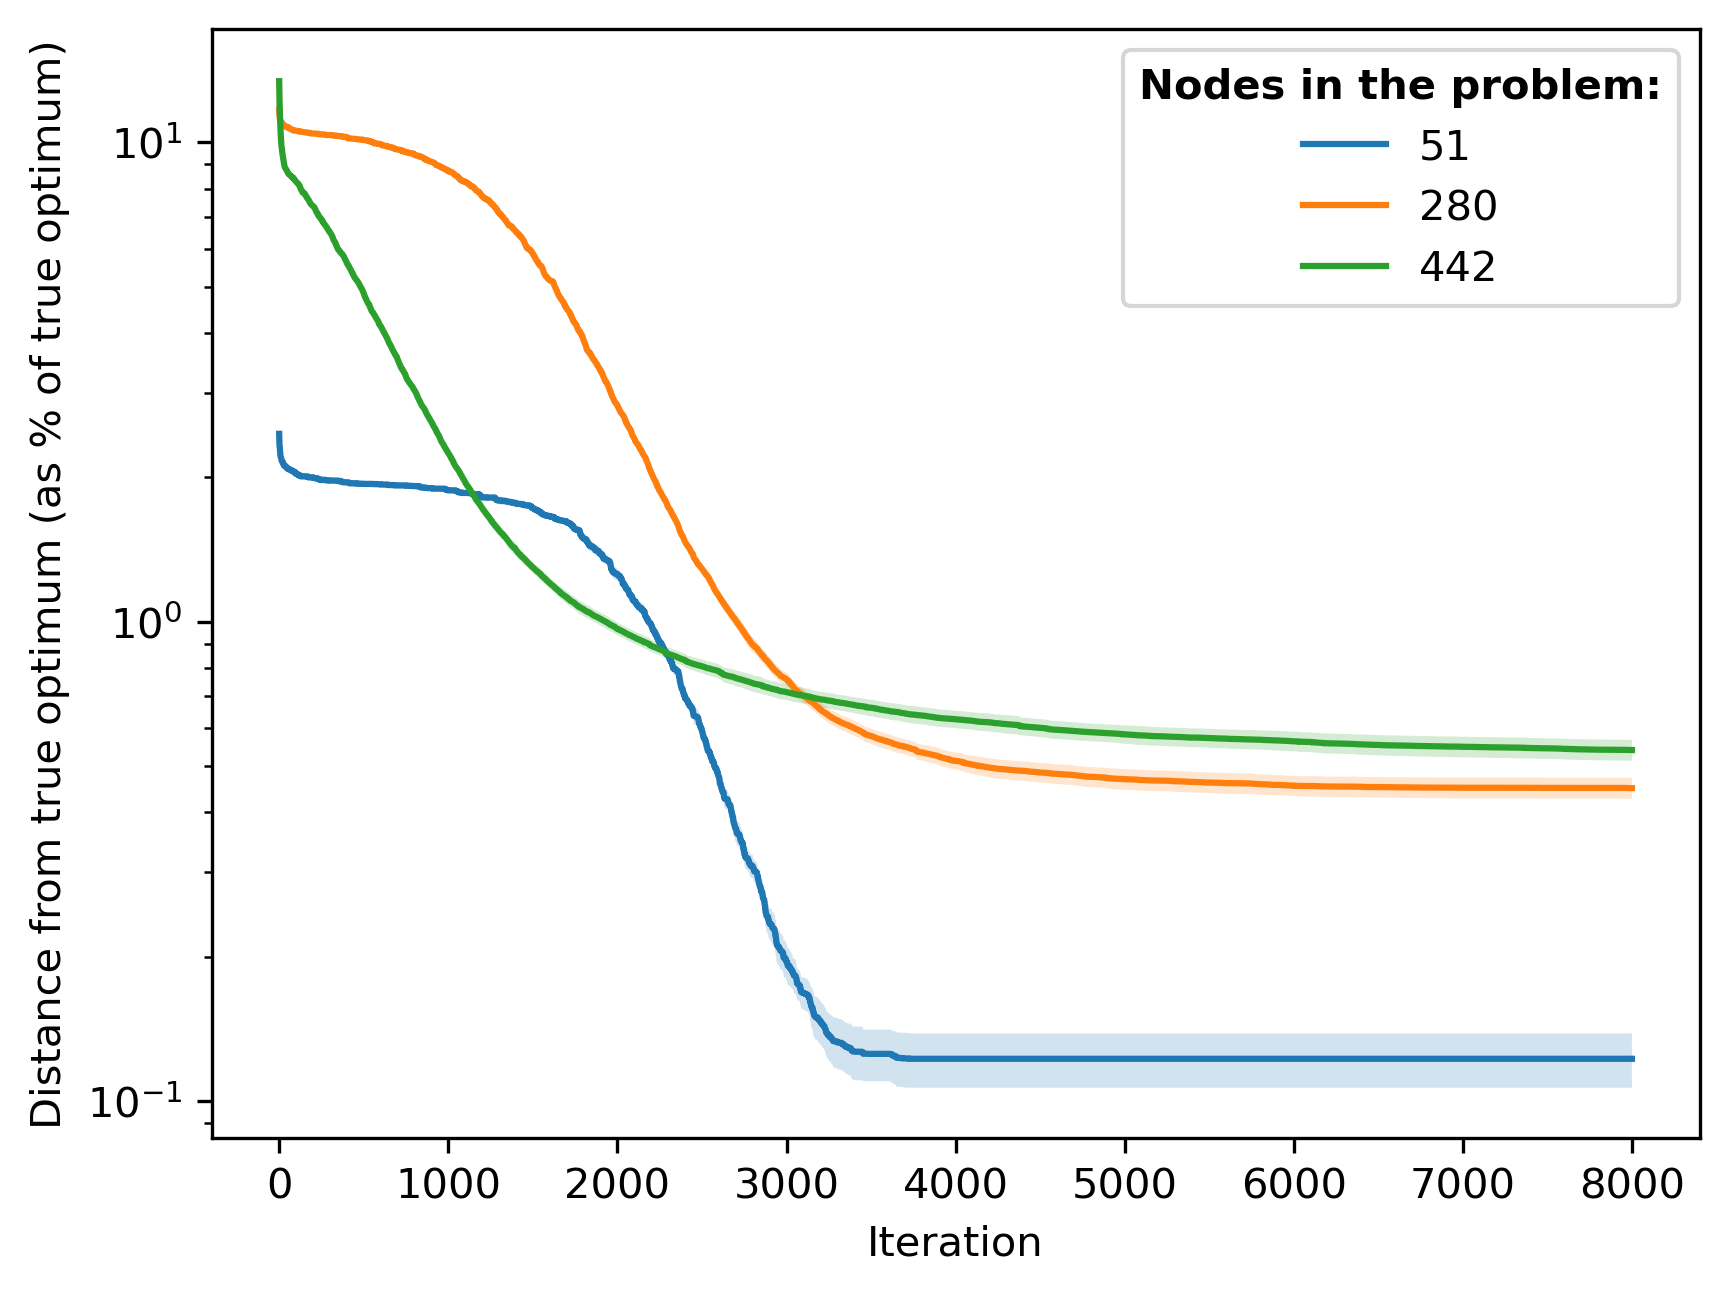

In [17]:
'''We plot the average convergence for our simulated annealing algorithm applied to every problem'''

# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
names = ["eil51.tsp.txt", "a280.tsp.txt", "pcb442.tsp.txt"]
opt_names = ["eil51.opt.tour.txt", "a280.opt.tour.txt", "pcb442.opt.tour.txt"]
labels = [51, 280, 442]

# Set the parameters
T0 = 1000
cooling_rate = 0.998
max_iterations = 8000
mc_length = 100

plt.figure(dpi = 300)

#Loop through the 3 different problems
for it, name in enumerate(names):
    all_results = []

    # Compute problem data (nodes names and distance matrix)
    nodes = read_tsp(name)
    dist_matrix = distance_matrix(nodes)

    true_opt = tot_distance(tour = read_tsp_opt(opt_names[it]), dist_matrix = dist_matrix) # Computes the length of the given solution

    # Run the algorithm 30 times
    for _ in range(30):
        _, _, dic_result = simulated_annealing(dist_matrix, T0, cooling_rate, mc_length, max_iterations)
        all_results.append((np.array(list(dic_result.values())) - true_opt)/true_opt)

    #Calculate the mean and confidence interval for the distance from the true optimum at every iteration of the slgorithm over the 30 runs
    all_results = np.array(all_results)
    mean, ci = confidence_interval(all_results)
    
    # Plot the results
    plt.plot(list(dic_result.keys()), mean, label = str(labels[it]))
    plt.fill_between(list(dic_result.keys()), mean - ci, mean + ci, alpha = 0.2)

plt.xlabel('Iteration')
plt.ylabel('Distance from true optimum (as % of true optimum)')
plt.yscale('log')
plt.legend(title = "Nodes in the problem:", title_fontproperties = {"weight": "heavy"})
plt.show()

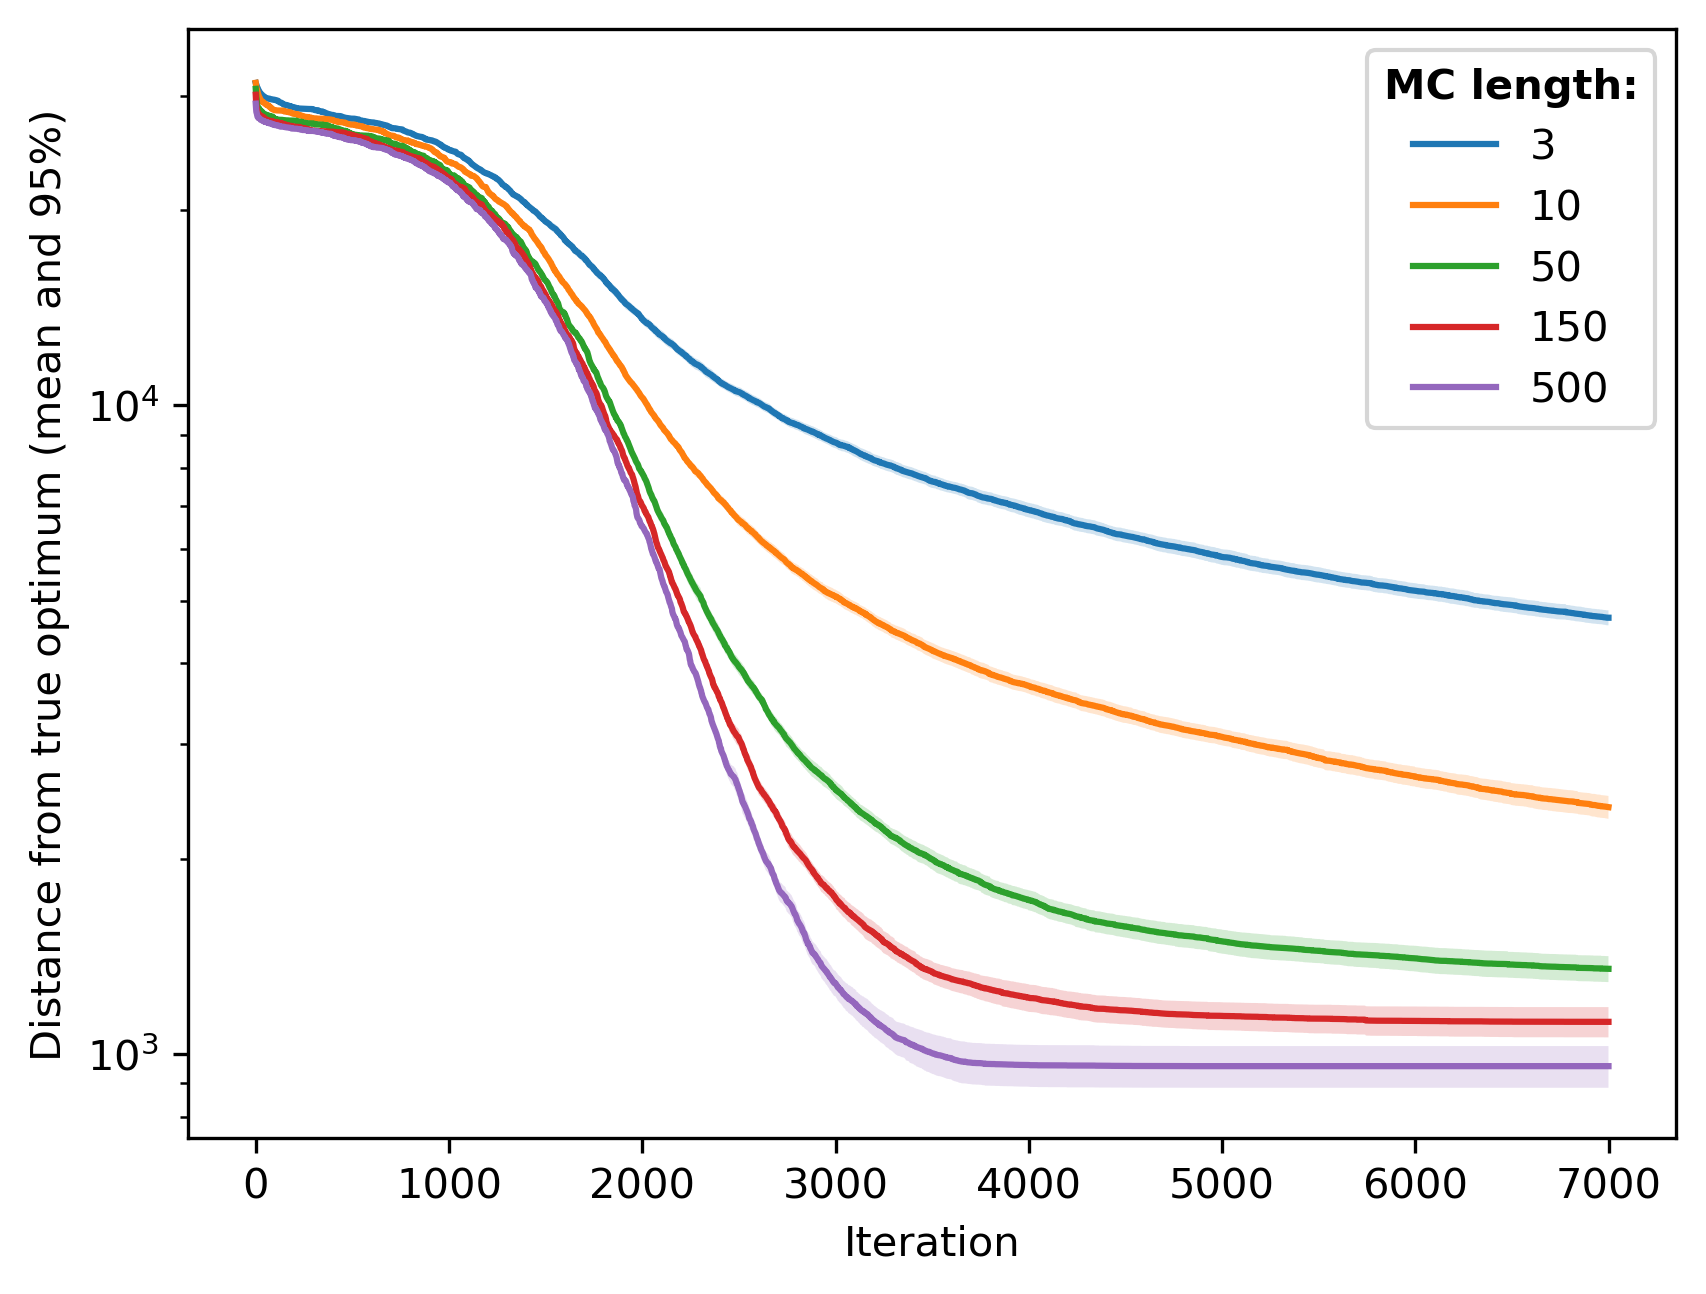

In [18]:
'''We now focus on the 280-cities problem and observe how the convergence changes as we increase the MC length'''

# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
name = "a280.tsp.txt"
nodes = read_tsp(name)
dist_matrix = distance_matrix(nodes)

# Set the parameters
T0 = 1000
cooling_rate = 0.998
max_iterations = 7000

true_opt = tot_distance(tour = read_tsp_opt("a280.opt.tour.txt"), dist_matrix = dist_matrix) # Compute length of true solution

plt.figure(dpi = 300)

# Loop through different MC lengths 
for mc in [3, 10, 50, 150, 500]:
    all_results = []
    
    # For every MC length, run the algorithm 30 times
    for it in range(30):
        _, _, dic_result = simulated_annealing(dist_matrix, T0, cooling_rate, mc_length = mc, max_iterations = max_iterations)
        all_results.append(np.array(list(dic_result.values())) - true_opt)
    
    # Compute the mean and CI over the 30 runs for every iteration
    all_results = np.array(all_results)
    mean, ci = confidence_interval(all_results)
    
    # Plot the results
    plt.plot(list(dic_result.keys()), mean, label = str(mc))
    plt.fill_between(list(dic_result.keys()), mean - ci, mean + ci, alpha = 0.2)

plt.xlabel('Iteration')
plt.ylabel('Distance from true optimum (mean and 95%)')
plt.yscale('log')
plt.legend(title = "MC length:", title_fontproperties = {"weight": "heavy"})
plt.show()

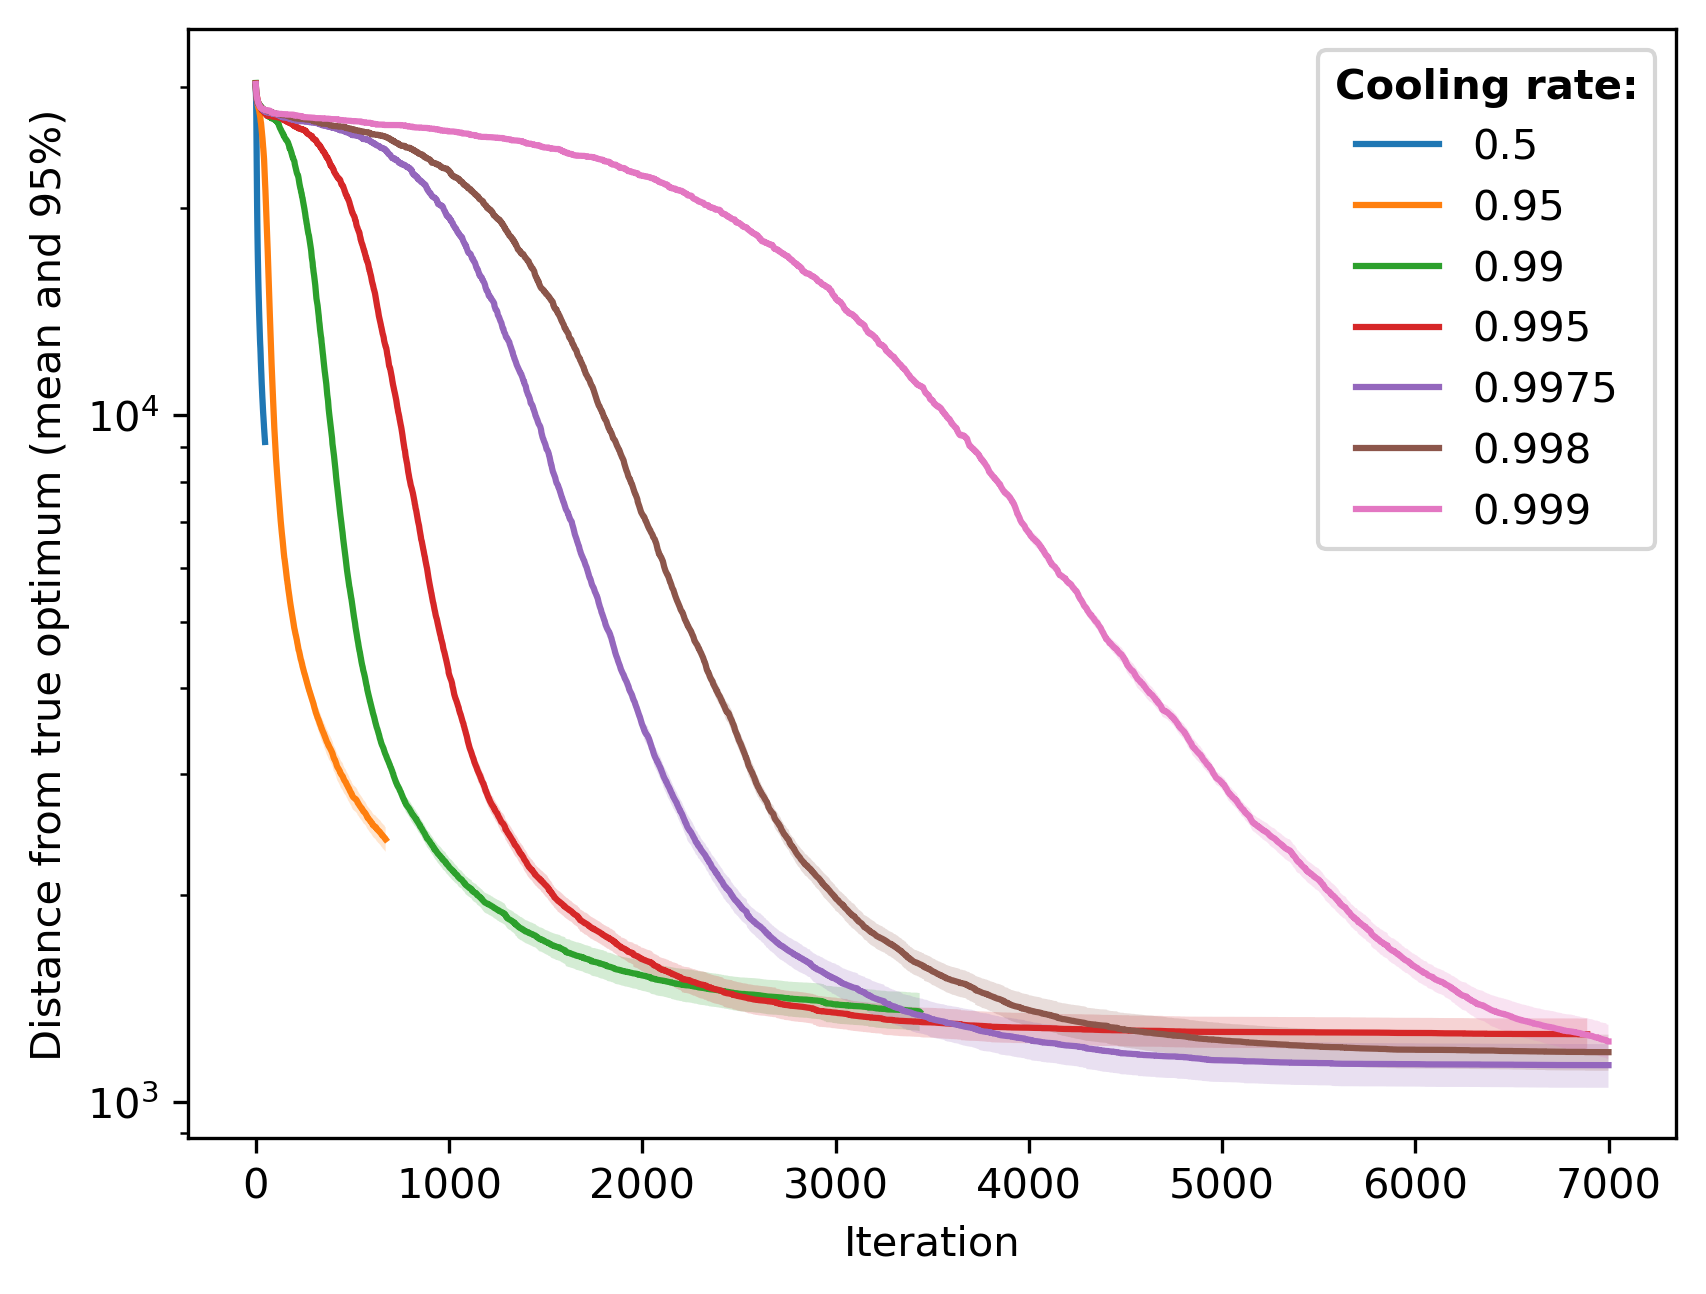

In [19]:
'''We now observe the effect on convergence of a change in the cooling schedule'''

# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
name = "a280.tsp.txt"
nodes = read_tsp(name)
dist_matrix = distance_matrix(nodes)

# Set the parameters
T0 = 1000
mc = 100
max_iterations = 7000

true_opt = tot_distance(tour = read_tsp_opt("a280.opt.tour.txt"), dist_matrix = dist_matrix) # Compute length of true solution

plt.figure(dpi = 300)

# Loop through different cooling rates
for cr in [0.5, 0.95, 0.99, 0.995, 0.9975, 0.998, 0.999]:
    all_results = []
    
    # For every cooling rate, run the algorithm 30 times
    for it in range(30):
        _, _, dic_result = simulated_annealing(dist_matrix, T0, cooling_rate = cr, mc_length = mc, max_iterations = max_iterations)
        all_results.append(np.array(list(dic_result.values())) - true_opt)
    
    # Compute the mean and CI over the 30 runs for every iteration
    all_results = np.array(all_results)
    mean, ci = confidence_interval(all_results)
    
    # Plot the results 
    plt.plot(list(dic_result.keys()), mean, label = str(cr))
    plt.fill_between(list(dic_result.keys()), mean - ci, mean + ci, alpha = 0.2)

plt.xlabel('Iteration')
plt.ylabel('Distance from true optimum (mean and 95%)')
plt.yscale('log')
plt.legend(title = "Cooling rate:", title_fontproperties = {"weight": "heavy"})
plt.show()

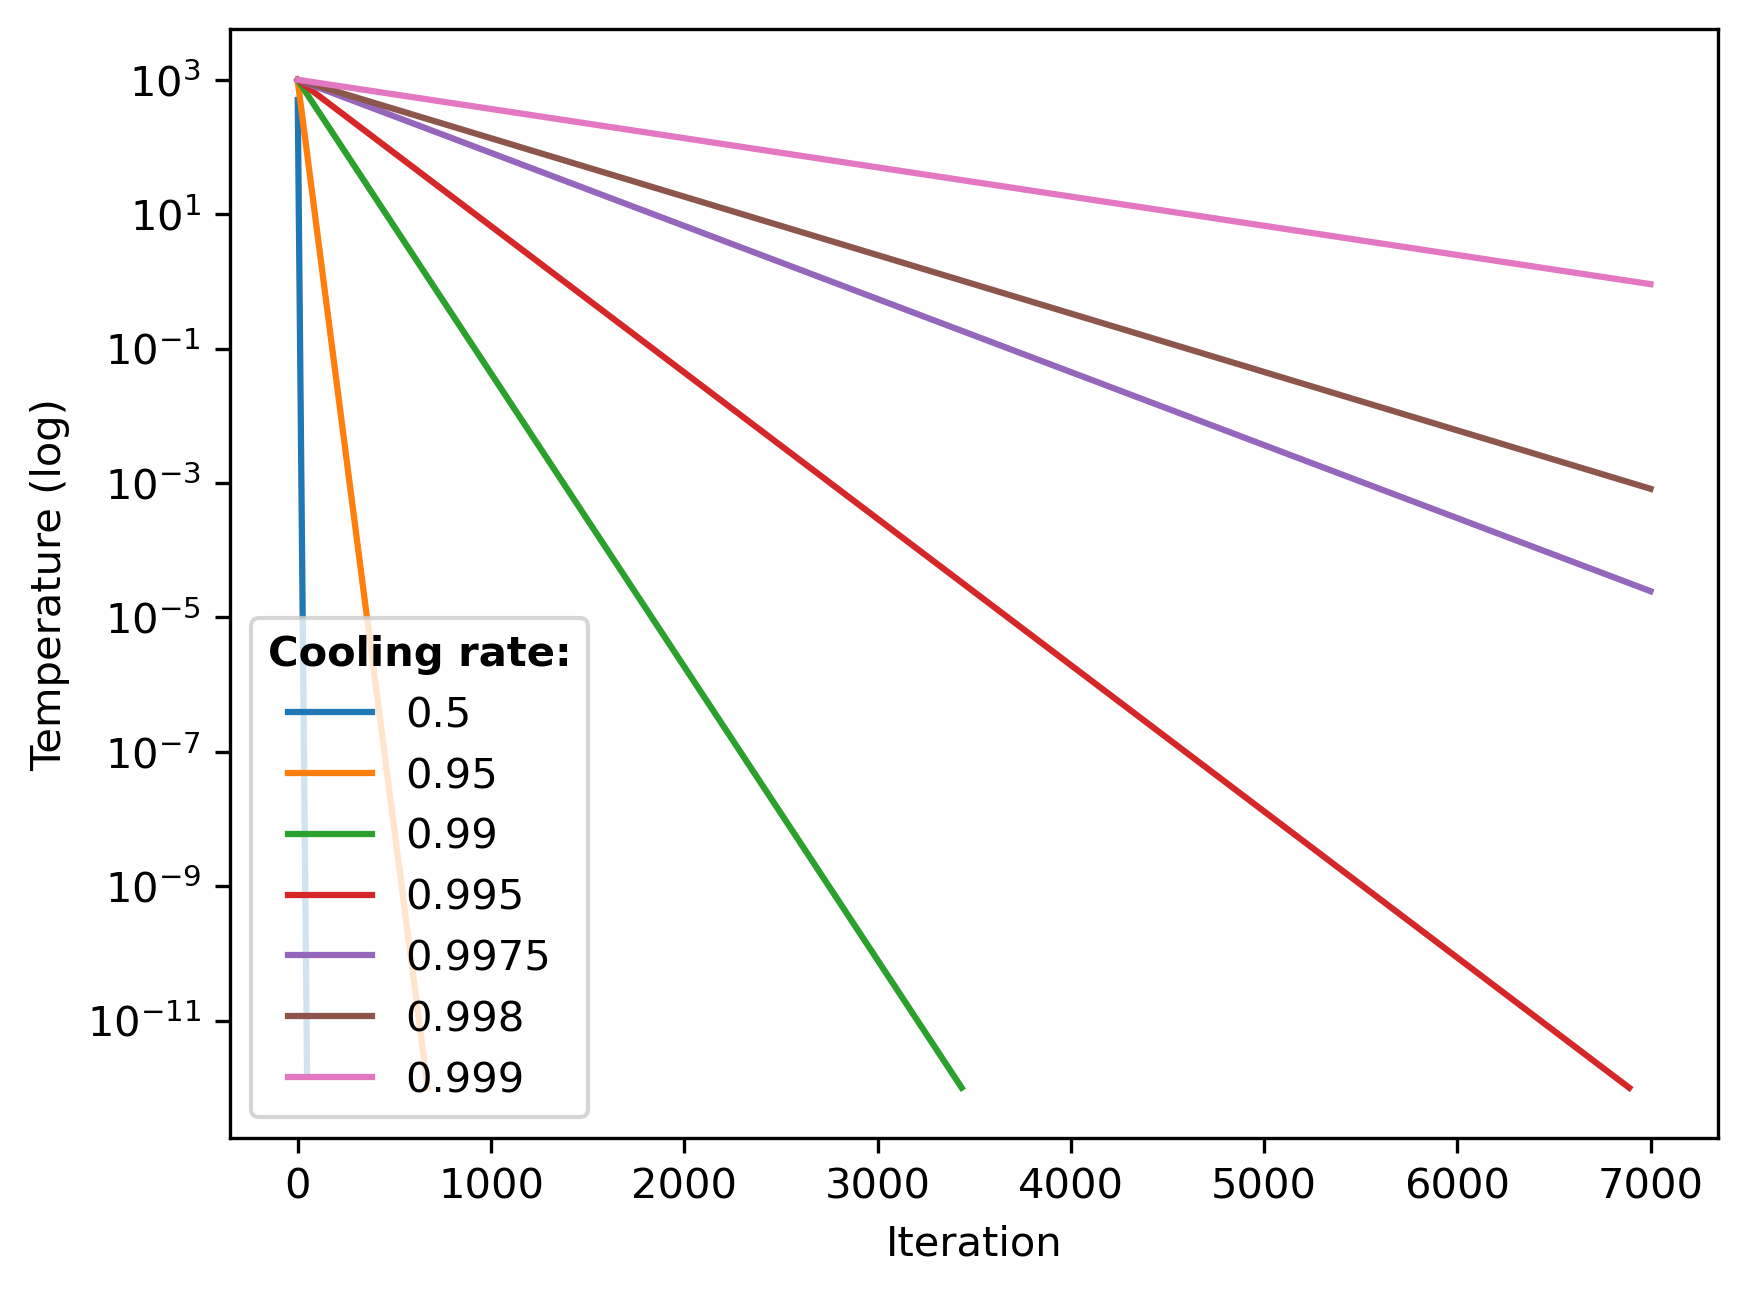

In [6]:
'''Here we observe the reason for which some of the lines in the graph above are interrupted before reaching the limit of 7000 iterations
This is due to the temperature reaching the cutoff limit of 1e-12 earlier, becasue of the faster schooling schedule (as it can be seen from the graph below).'''

def temperature_analysis(T0, cooling_rate, max_iterations): # Simulate the behaviour of the temperature in the simulated annealing algorithm
    
    dic_result = {}

    T = T0 # Set an initial temperature

    for iteration in range(max_iterations): # Loop through a maximum number of iterations
                
        T *= cooling_rate # Upgrade the temperature according the cooling rate
        if T < 1e-12: # Break the loop if the temperature becomes too small
            break

        dic_result[iteration] = T

    return dic_result

# Set the parameters
T0 = 1000
max_iterations = 7000

plt.figure(dpi = 300)
# Loop through different cooling rates
for cr in [0.5, 0.95, 0.99, 0.995, 0.9975, 0.998, 0.999]:

    # Run the temperature drop simulation
    dic_result = temperature_analysis(T0, cooling_rate = cr, max_iterations = max_iterations)

    # Plot the results
    plt.plot(list(dic_result.keys()), list(dic_result.values()), label = str(cr))

plt.xlabel('Iteration')
plt.ylabel('Temperature (log)')
plt.yscale('log')
plt.legend(title = "Cooling rate:", title_fontproperties = {"weight": "heavy"})
plt.show()